In [9]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mrcnn.config import Config
#import utils
from mrcnn import model as modellib
from mrcnn import utils

from mrcnn import visualize
import yaml
from mrcnn.model import log
from PIL import Image

In [10]:
ROOT_DIR = os.path.abspath("")
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
print(MODEL_DIR)
iter_num=0

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


/home/ljt/Mask_RCNN/logs


In [11]:

class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shape"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 8  # background + 6 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 320
    IMAGE_MAX_DIM = 384

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8 * 6, 16 * 6, 32 * 6, 64 * 6, 128 * 6)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 100

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 50



config = ShapesConfig()
# config.display()


In [39]:

class DrugDataset(utils.Dataset):
    # 得到该图中有多少个实例（物体）
    def get_obj_index(self, image):
        n = np.max(image)
        return n

    # 解析labelme中得到的yaml文件，从而得到mask每一层对应的实例标签
    def from_yaml_get_class(self, image_id):
        info = self.image_info[image_id]
        with open(info['yaml_path']) as f:
            temp = yaml.load(f.read())
            labels = temp['label_names']
            del labels[0]
        return labels

    # 重新写draw_mask
    def draw_mask(self, num_obj, mask, image,image_id):
        #print("draw_mask-->",image_id)
        #print("self.image_info",self.image_info)
        info = self.image_info[image_id]
        #print("info-->",info)
        #print("info[width]----->",info['width'],"-info[height]--->",info['height'])
        for index in range(num_obj):
            for i in range(info['width']):
                for j in range(info['height']):
                    #print("image_id-->",image_id,"-i--->",i,"-j--->",j)
                    #print("info[width]----->",info['width'],"-info[height]--->",info['height'])
                    at_pixel = image.getpixel((i, j))
                    if at_pixel == index + 1:
                        mask[j, i, index] = 1
        return mask

    # 重新写load_shapes，里面包含自己的类别,可以任意添加
    # 并在self.image_info信息中添加了path、mask_path 、yaml_path
    # yaml_pathdataset_root_path = "/tongue_dateset/"
    # img_floder = dataset_root_path + "rgb"
    # mask_floder = dataset_root_path + "mask"
    # dataset_root_path = "/tongue_dateset/"
    def load_shapes(self, count, img_floder, mask_floder, imglist, dataset_root_path):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes,可通过这种方式扩展多个物体
        self.add_class("shapes", 1, "high-heeled")
        self.add_class("shapes", 2, "high-heeled-welt")
        self.add_class("shapes", 3, "sports")
        self.add_class("shapes", 4, "sports-welt")
        self.add_class("shapes", 5, "sandals")
        self.add_class("shapes", 6, "sandals-welt")
        self.add_class("shapes", 7, "slippers")
        self.add_class("shapes", 8, "slippers-welt")

        for i in range(count):
            # 获取图片宽和高

            filestr = imglist[i].split(".")[0]
            #print(imglist[i],"-->",cv_img.shape[1],"--->",cv_img.shape[0])
            #print("id-->", i, " imglist[", i, "]-->", imglist[i],"filestr-->",filestr)
            #filestr = filestr.split("_")[1]
            mask_path = mask_floder + "/" + filestr + ".png"
            yaml_path = dataset_root_path + "labelme_json/" + filestr + "_json/info.yaml"
            # print(dataset_root_path + "labelme_json/" + filestr + "_json/img.png")
            cv_img = cv2.imread(dataset_root_path + "pic/" + filestr + ".png")

            self.add_image("shapes", image_id=i, path=img_floder + "/" + imglist[i],
                           width=cv_img.shape[1], height=cv_img.shape[0], mask_path=mask_path, yaml_path=yaml_path)

    # 重写load_mask
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        global iter_num
        print("image_id",image_id)
        info = self.image_info[image_id]
        count = 1  # number of object
        img = Image.open(info['mask_path'])
        num_obj = self.get_obj_index(img)
        mask = np.zeros([info['height'], info['width'], num_obj], dtype=np.uint8)
        mask = self.draw_mask(num_obj, mask, img,image_id)
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count - 2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion

            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        labels = []
        labels = self.from_yaml_get_class(image_id)
        labels_form = []
        for i in range(len(labels)):
            if labels[i].find("high-heeled") != -1:
                labels_form.append("high-heeled")
            elif labels[i].find("high-heeled-welt") != -1:
                labels_form.append("high-heeled-welt")
            elif labels[i].find("sports") != -1:
                labels_form.append("sports")
            elif labels[i].find("sports-welt") != -1:
                labels_form.append("sports-welt")
            elif labels[i].find("sandals") != -1:
                labels_form.append("sandals")
            elif labels[i].find("sandals-welt") != -1:
                labels_form.append("sandals-welt")
            elif labels[i].find("slippers") != -1:
                labels_form.append("slippers")
            elif labels[i].find("slippers-welt") != -1:
                labels_form.append("slippers-welt")





        class_ids = np.array([self.class_names.index(s) for s in labels_form])
        return mask, class_ids.astype(np.int32)



In [40]:
dataset_root_path=ROOT_DIR+"/corner_data/"
dataset_root_path="/home/ljt/Desktop/for_server/"
img_floder = dataset_root_path + "pic"
# print(img_floder)
mask_floder = dataset_root_path + "cv2_mask"
#yaml_floder = dataset_root_path
imglist = os.listdir(img_floder)
count = len(imglist)
#print(imglist)
#print(count)

#train与val数据集准备
dataset_train = DrugDataset()
dataset_train.load_shapes(count, img_floder, mask_floder, imglist, dataset_root_path)
dataset_train.prepare()
dataset_val = DrugDataset()
dataset_val.load_shapes(10, img_floder, mask_floder, imglist, dataset_root_path)
dataset_val.prepare()
print("dataset_val-->",dataset_val._image_ids)

dataset_val--> [0 1 2 3 4 5 6 7 8 9]


image_id 279


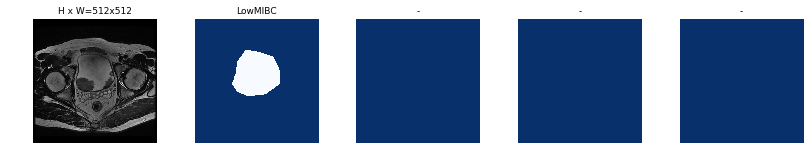

image_id 807


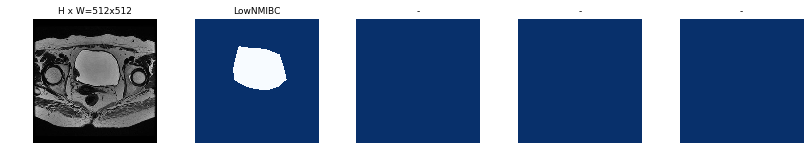

image_id 685


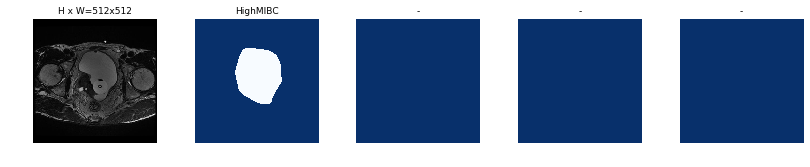

image_id 604


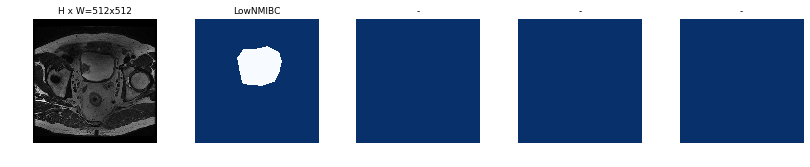

In [41]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

image_id 3


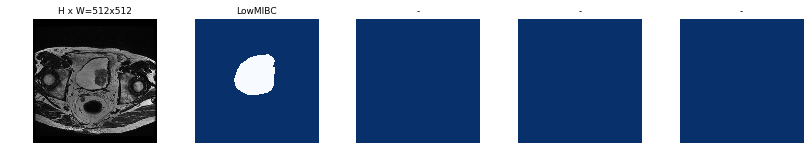

image_id 6


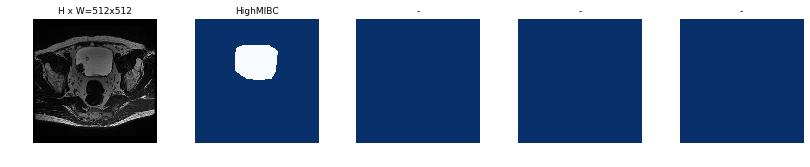

image_id 1


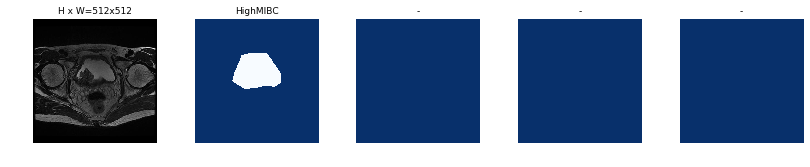

image_id 5


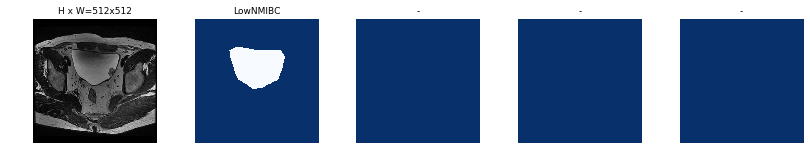

In [38]:
image_ids = np.random.choice(dataset_val.image_ids, 4)
for image_id in image_ids:
   image = dataset_train.load_image(image_id)
   mask, class_ids = dataset_train.load_mask(image_id)
   visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [42]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)
init_with = "coco"  # imagenet, coco, or last


if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [17]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE/10,
            epochs=110,
            layers='all')


Starting at epoch 0. LR=0.0001

Checkpoint Path: /home/ljt/Mask_RCNN/logs/shape20190608T1343/mask_rcnn_shape_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b

/home/ljt/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/home/ljt/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/engine/training_generator.py:44: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


image_id 614


image_id 38


image_id 685


image_id 788


image_id 740


image_id 428


image_id 680


image_id 641


image_id 806


image_id 496


image_id 41


image_id 30


image_id 784


image_id 684


Epoch 1/110


image_id 742


image_id 616


image_id 716


image_id 517


image_id 693


image_id 828


image_id 796


image_id 714


image_id 659


image_id 756


image_id 202


image_id 167


image_id 233


image_id 736


image_id 235


image_id 121


image_id 229


image_id 835


image_id 653


image_id 433


image_id 490


image_id 503


image_id 512


image_id 326


image_id 461


image_id 165


image_id 80


image_id 207


image_id 546


image_id 37


image_id 176


image_id 375


ERROR:root:Error processing image {'id': 121, 'source': 'shapes', 'path': '/home/ljt/Desktop/for server/pic/251.png', 'width': 512, 'height': 512, 'mask_path': '/home/ljt/Desktop/for server/cv2_mask/251.png', 'yaml_path': '/home/ljt/Desktop/for server/labelme_json/251_json/info.yaml'}
Traceback (most recent call last):
  File "/home/ljt/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/ljt/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-11-14a1a5c7ba23>", line 90, in load_mask
    class_ids = np.array([self.class_names.index(s) for s in labels_form])
  File "<ipython-input-11-14a1a5c7ba23>", line 90, in <listcomp>
    class_ids = np.array([self.class_names.index(s) for s in labels_form])
ValueError: 'Low' is not in list

image_id 204


image_id 475


image_id 40


image_id 247


image_id 57


image_id 402


image_id 520


ERROR:root:Error processing image {'id': 37, 'source': 'shapes', 'path': '/home/ljt/Desktop/for server/pic/773.png', 'width': 512, 'height': 512, 'mask_path': '/home/ljt/Desktop/for server/cv2_mask/773.png', 'yaml_path': '/home/ljt/Desktop/for server/labelme_json/773_json/info.yaml'}
Traceback (most recent call last):
  File "/home/ljt/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/ljt/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-11-14a1a5c7ba23>", line 90, in load_mask
    class_ids = np.array([self.class_names.index(s) for s in labels_form])
  File "<ipython-input-11-14a1a5c7ba23>", line 90, in <listcomp>
    class_ids = np.array([self.class_names.index(s) for s in labels_form])
ValueError: 'Low' is not in list

image_id 234


image_id 723


image_id 480


image_id 618


image_id 228


image_id 773


image_id 779


image_id 627


image_id 489


image_id 594


ERROR:root:Error processing image {'id': 234, 'source': 'shapes', 'path': '/home/ljt/Desktop/for server/pic/787.png', 'width': 512, 'height': 512, 'mask_path': '/home/ljt/Desktop/for server/cv2_mask/787.png', 'yaml_path': '/home/ljt/Desktop/for server/labelme_json/787_json/info.yaml'}
Traceback (most recent call last):
  File "/home/ljt/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/ljt/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-11-14a1a5c7ba23>", line 90, in load_mask
    class_ids = np.array([self.class_names.index(s) for s in labels_form])
  File "<ipython-input-11-14a1a5c7ba23>", line 90, in <listcomp>
    class_ids = np.array([self.class_names.index(s) for s in labels_form])
ValueError: 'High' is not in list

image_id 810


image_id 331


image_id 392


image_id 618


image_id 6


image_id 771


image_id 792


image_id 729


image_id 83


image_id 793


image_id 758


image_id 43


image_id 622


image_id 409


image_id 651


image_id 526


image_id 546


image_id 168


image_id 535


image_id 663


image_id 591


image_id 713


image_id 478


image_id 293


image_id 512


image_id 183


image_id 122


ERROR:root:Error processing image {'id': 651, 'source': 'shapes', 'path': '/home/ljt/Desktop/for server/pic/86.png', 'width': 512, 'height': 512, 'mask_path': '/home/ljt/Desktop/for server/cv2_mask/86.png', 'yaml_path': '/home/ljt/Desktop/for server/labelme_json/86_json/info.yaml'}
Traceback (most recent call last):
  File "/home/ljt/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/ljt/Mask_RCNN/mrcnn/model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-11-14a1a5c7ba23>", line 90, in load_mask
    class_ids = np.array([self.class_names.index(s) for s in labels_form])
  File "<ipython-input-11-14a1a5c7ba23>", line 90, in <listcomp>
    class_ids = np.array([self.class_names.index(s) for s in labels_form])
ValueError: 'Low' is not in list

image_id 788


image_id 506


image_id 205


image_id 6


image_id 807


image_id 644


image_id 348


image_id 328


image_id 59


ValueError: Error when checking input: expected input_image_meta to have shape (16,) but got array with shape (14,)

In [54]:
class Detect_Config(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
detectconfig=Detect_Config()
model = modellib.MaskRCNN(mode="inference", config=detectconfig,
                          model_dir=MODEL_DIR)
SHARP_MODEL_DIR=os.path.join(MODEL_DIR,"logs/shape20190608T1400")
#SHARP_MODEL_PATH=os.path.join(SHARP_MODEL_DIR,"mask_rcnn_shapes_0000.h5")
SHARP_MODEL_PATH="logs/shape20190609T2035/mask_rcnn_shape_0060.h5"
model.load_weights(SHARP_MODEL_PATH, by_name=True)
print(SHARP_MODEL_PATH)


Re-starting from epoch 60
logs/shape20190609T2035/mask_rcnn_shape_0060.h5


Processing 1 images
image                    shape: (512, 512)            min:    0.00000  max:  253.00000  uint8


ValueError: Unable to create correctly shaped tuple from [(0, 0), (0, 0), (0, 0)]

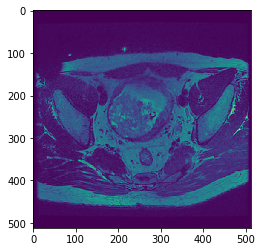

In [55]:
import skimage
Quilt_DIR=os.path.join(ROOT_DIR,"quilt_data")
Quilt_DIR="/home/ljt/Desktop/for_server/"
IMAGE_DIR=os.path.join(Quilt_DIR,"pic")
image = skimage.io.imread(os.path.join(IMAGE_DIR, "17.png"))
# image = skimage.io.imread("C:/Users/VCC/Desktop/3.jpg")
plt.imshow(image)
# Run detection
results = model.detect([image], verbose=1)
# print(image)
# Visualize results
# r = results[0]
# count=0
# mask=np.zeros((r['masks'].shape[0],r['masks'].shape[1]))
# print(r['masks'].shape)
# for i in range(r['masks'].shape[0]):
#     for j in range(r['masks'].shape[1]):
#         if r['masks'][i][j][0]:
#             count+=1
#             mask[i][j]+=1
# print(count)
# plt.imshow(mask,cmap='gray')

# plt.imshow(visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                             dataset_val.class_names, r['scores']))


TypeError: Image data cannot be converted to float

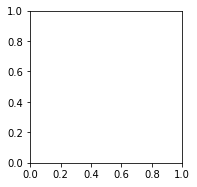

In [49]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
img = cv2.imread('C:/Users/VCC/Desktop/image.jpg',0)
img = cv2.GaussianBlur(img,(3,3),0)
edges = cv2.Canny(img,50,150)

plt.subplot(121),plt.imshow(img,cmap='gray')
plt.title('original'),plt.xticks([]),plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap='gray')
plt.title('edge'),plt.xticks([]),plt.yticks([])

plt.show()